## ПРОЕКТ: ВРЕМЕННЫЕ РЯДЫ

### ОПИСАНИЕ ПРОЕКТА

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.\
Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

### ЗАДАЧА ПРОЕКТА

Нужно построить модель для предсказания количества заказов такси на следующий час.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### ПЛАН ПРОЕКТА

1. [Загрузка и изучение данных](#1)
2. [Предобработка данных](#process)
3. [Исследовательский анализ данных](#research)
4. [Составление портрета пользователя каждого региона](#portrait)
5. [Общий вывод по проекту](#conclusion)

<a id="1"></a>
# Загрузка и изучение данных

## Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [3]:
# импорт pandas и необходимых библиотек
import jupyter_black
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файл, прочтем и запишем в переменную.

In [4]:
# объявление переменных
taxi_file = "dataset.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(
                path1,
                index_col=["datetime"],
                parse_dates=["datetime"],
            )
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(
                path2,
                index_col=["datetime"],
                parse_dates=["datetime"],
            )
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную train_job_df
taxi_df = get_read_file(general_path, user_path, taxi_file)

***

**ВЫВОД:**

1. Данные получены в файле ***"dataset.csv"*** и записаны в датафрейм ***"taxi_df"***

## Изучение данных

Изучим общую информацию о полученном датафрейме

In [5]:
# вывод первых 5-ти строчек датафрейма
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# вывод основной информации о датафрейме
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индексы датафрейма.
Проверим, в хронологическом ли порядке расположены даты и время в датафрейме.

In [7]:
# сортировка индекса
taxi_df.sort_index(inplace=True)
# проверка на монотонность
print(taxi_df.index.is_monotonic_increasing)

True


Ресемплируем данные по одному часу.

In [8]:
# ресемплирование датафрейма
taxi_df = taxi_df.resample("1H").sum()

***

**ВЫВОД:**

1. Данные были отсортированы по индексу и проверены на монотонность.
2. Было выполнено ресемплирование по одному часу.

# Анализ данных

Посмотрим, как применилось ресемплирование к датафрейму

In [9]:
# вывод первых 5-ти строчек датафрейма
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Выведем описательную статистику датафрейма

In [10]:
# вывод описательной статистики
taxi_df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В датафрейме 4416 строк со значениями от 0 до 462 и средним 84,42

Проведём разложение на тренды и сезонность

Применим ресемплирование по одному дню и проверим тренды и сезонность по дням недели

In [11]:
# применение функции разложения
decomposed = seasonal_decompose(taxi_df["2018-03":"2018-04"].resample("1D").sum())

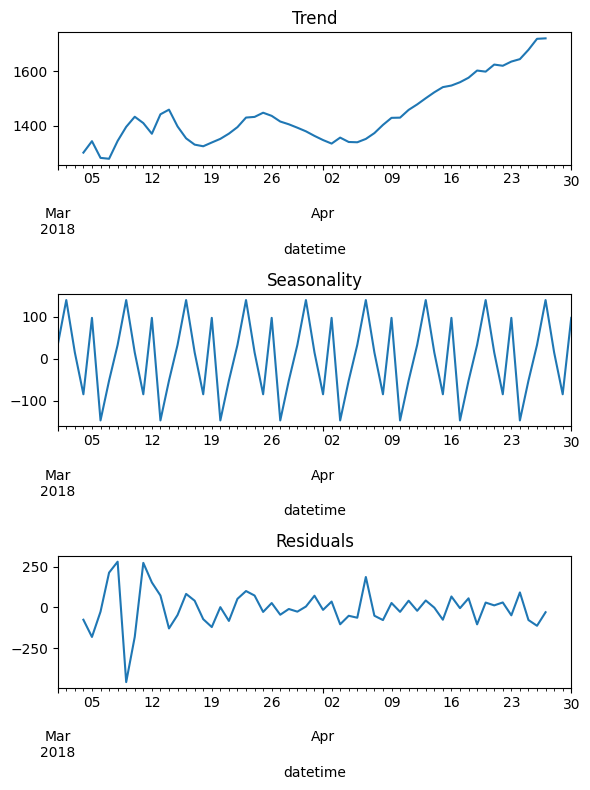

In [12]:
# построение графиков
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title("Trend")
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Seasonality")
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title("Residuals")
plt.tight_layout()

Тренд: заметно увеличение значений.
Сезонность: чёткие периоды сезонности.
Остатки: неравномерные.

Обратим внимание на сезонность

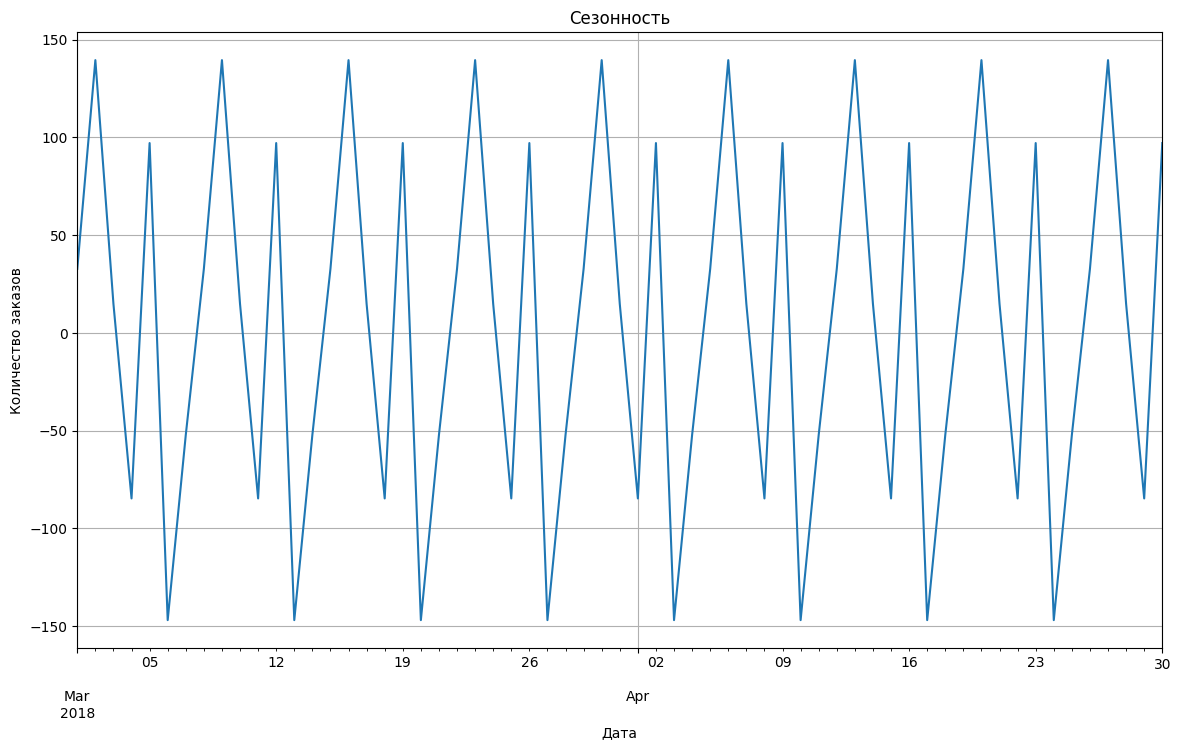

In [13]:
# визуализация сезонности
plt.figure(figsize=(14, 8))
decomposed.seasonal.plot()
plt.title("Сезонность")
plt.xlabel("Дата")
plt.xticks()
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

На графике явно видны сезонные колебания с периодичностью в 7 дней.

Посмотрим на сезонные колебания на примере одной недели

In [14]:
# запись во вспомогательный датафрейм
dow_df = taxi_df["2018-03-05":"2018-03-11"].resample("1D").sum()
dow_df["date"] = dow_df.index
dow_df["day_of_week"] = dow_df["date"].dt.day_name()

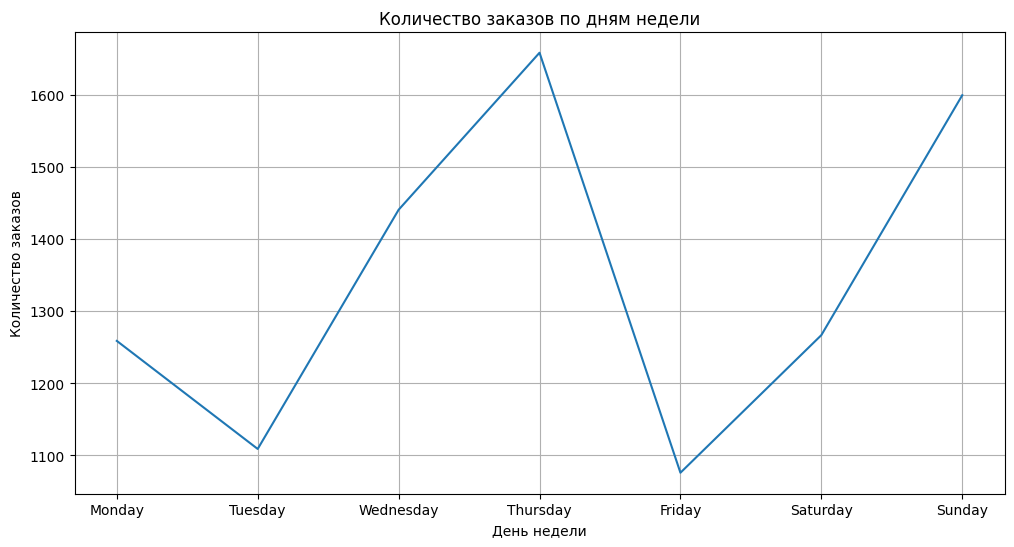

In [15]:
# построение графика
plt.figure(figsize=(12, 6))
plt.plot(
    dow_df["day_of_week"],
    dow_df["num_orders"],
    linestyle="-",
)
plt.title("Количество заказов по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

В сезонности отмечаются 2 пика значений: в четверг и воскресенье.
Также видны 2 минимума: во вторник и пятницу.

Проверим тренды и сезонность по времени суток

In [16]:
# применение функции разложения
decomposed = seasonal_decompose(taxi_df["2018-03-01":"2018-03-03"])

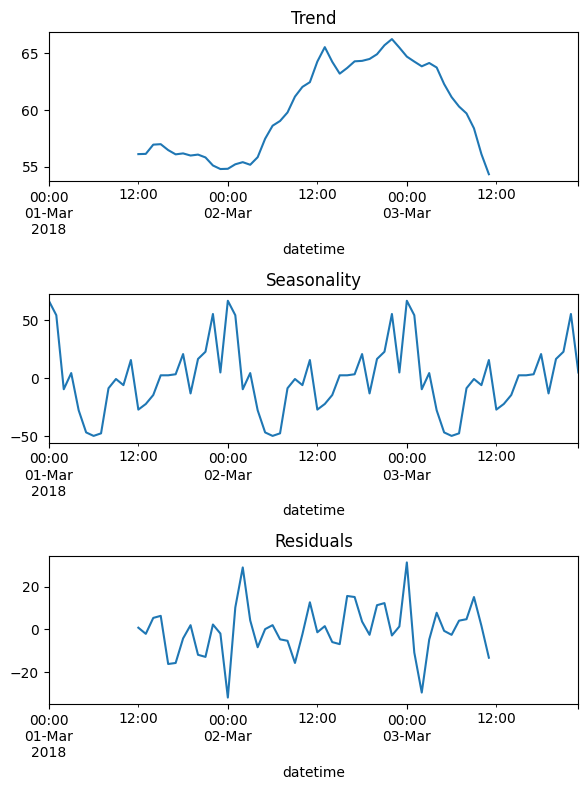

In [17]:
# построение графиков
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title("Trend")
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Seasonality")
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title("Residuals")
plt.tight_layout()

Тренд: нет выраженного.
Сезонность: чёткие периоды сезонности.
Остатки: равномерно распределены около нуля.

На графике явно видны сезонные колебания с периодичностью в сутки.

Посмотрим на сезонные колебания на примере одних суток

In [18]:
# запись во вспомогательный датафрейм
day_df = taxi_df["2018-03-01":"2018-03-01"]

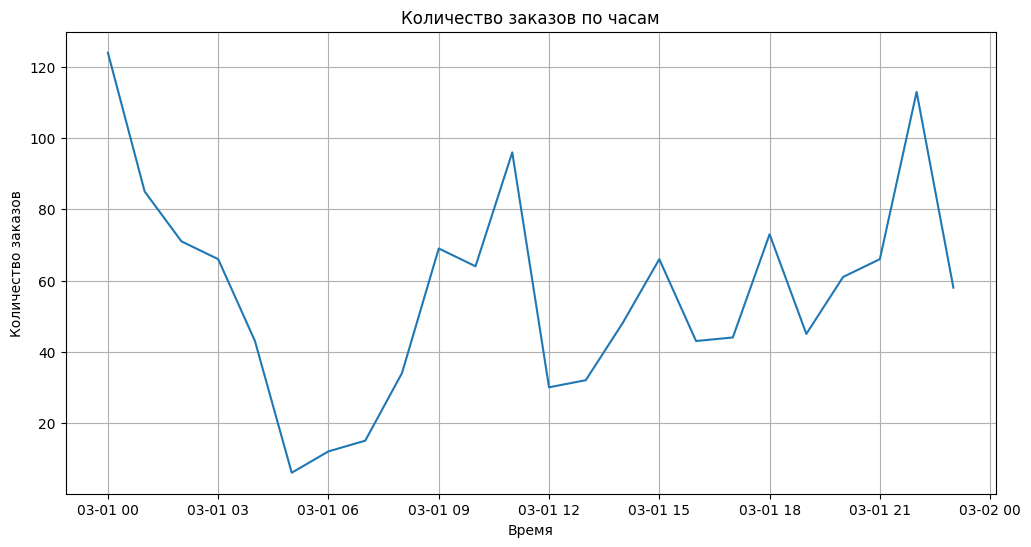

In [19]:
# построение графика
plt.figure(figsize=(12, 6))
plt.plot(
    day_df.index,
    day_df["num_orders"],
    linestyle="-",
)
plt.title("Количество заказов по часам")
plt.xlabel("Время")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

Сезонность в течении суток имеет 3 пика значений: в полночь, в 11 часов и в 22 часа.
Также есть 2 минимума: в 5 часов утра и полдень.

***

**ВЫВОД:**

1. В датафрейме 4416 строк со значениями от 0 до 462 и средним 84,42
2. Было применено ресемплирование по одному дню и проверены тренды и сезонность по дням недели
3. По дням недели:
   - Тренд: заметно увеличение значений.
   - Сезонность: чёткие периоды сезонности.
   - Остатки: неравномерные.
4. На графике явно видны сезонные колебания с периодичностью в 7 дней.
5. В сезонности отмечаются 2 пика значений: в четверг и воскресенье.
   Также видны 2 минимума: во вторник и пятницу.
6. Были проверены тренды и сезонность по времени суток
7. По времени суток:
   - Тренд: нет выраженного.
   - Сезонность: чёткие периоды сезонности.
   - Остатки: равномерно распределены около нуля.
8. На графике явно видны сезонные колебания с периодичностью в сутки.
9. Сезонность в течении суток имеет 3 пика значений: в полночь, в 11 часов и в 22 часа.
   Также есть 2 минимума: в 5 часов утра и полдень.

# Обучение моделей

## Создание признаков

Создадим признаки для прогнозирования:
- календарные: `'month'`, `'day'`, `'dayofweek'`, `'hour'`
- отстающие значения: `'lag_1'`,	`'lag_2'`,	`'lag_3'`,	`'lag_4'`
- скользящее среднее: `'rolling_mean'`

In [20]:
# объявление функции для создания признаков
def make_features(df, max_lag, rolling_mean_size):
    df = df.copy()
    df["month"] = df.index.month
    df["day"] = df.index.day
    df["dayofweek"] = df.index.dayofweek
    df["hour"] = df.index.hour

    for lag in range(1, max_lag + 1):
        df["lag_{}".format(lag)] = df["num_orders"].shift(lag)

    df["rolling_mean"] = df["num_orders"].shift().rolling(rolling_mean_size).mean()
    return df


# вызов функции
df = make_features(taxi_df, 24, 24)

Проверим создание признаков

In [21]:
# вывод первых строк датафрейма
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка данных

Так как тагрет - количественный признак, будем решать задачу регрессии.

Сформируем тренировочную и тестовую выборки.

In [22]:
# формирование тренировочной и тестовой выборок
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Проверим разделение.

In [23]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [24]:
# вывод размеров выборок
train.shape, test.shape

((3950, 30), (442, 30))

В выборках выделим входные признаки и таргет. 

In [25]:
# разделение на входные признаки и таргет
X_train = train.drop(columns="num_orders")
y_train = train["num_orders"]
X_test = test.drop(columns="num_orders")
y_test = test["num_orders"]

Создадим пайплайн

In [26]:
# создание pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("models", LinearRegression()),
    ]
)

## Выбор модели и расчёт метрики

Будем обучать модели с гиперпараметрами:
 - LinearRegression()
 - DecisionTreeRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
 - RandomForestRegressor() с ***max_depth***, ***n_estimators***
 - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***

Для подбора лучшей модели с гиперпараметрами будем использовать
 - RandomizedSearchCV()

Для оценки качества работы модели применим метрику RMSE

Опишем модели с гиперпараметрами

In [27]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        "models": [LinearRegression()],
    },
    # словарь для модели DecisionTreeRegressor()
    {
        "models": [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(3, 10),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 10),
    },
    # словарь для модели RandomForestRegressor()
    {
        "models": [RandomForestRegressor(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 20, 2),
        "models__n_estimators": range(3, 20, 2),
    },
    # словарь для модели GradientBoostingRegressor()
    {
        "models": [GradientBoostingRegressor()],
        "models__max_depth": range(3, 10),
        "models__min_samples_split": range(2, 10),
        "models__min_samples_leaf": range(2, 10),
    },
]

Выберем лучшую модель с гиперпараметрами с помощью GridSearchCV()

In [28]:
# подбор лучшей модели с гиперпараметрами
rs = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_root_mean_squared_error",
    n_iter=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
rs.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", rs.best_estimator_)
print(
    f"Качество модели на кросс-валидации по метрике RMSE - {round(rs.best_score_, 3)*-1}"
)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 GradientBoostingRegressor(max_depth=4, min_samples_leaf=6))])
Качество модели на кросс-валидации по метрике RMSE - 24.734


***

**ВЫВОД:**

1. Были созданы новые признаки для прогнозирования:
   - календарные: `'month'`, `'day'`, `'dayofweek'`, `'hour'`
   - отстающие значения: `'lag_1'`,	`'lag_2'`,	и т.д. до `'lag_24'`
   - скользящее среднее: `'rolling_mean'`
2. Так как тагрет - количественный признак, будем решать задачу регрессии.
3. Были обучены модели с гиперпараметрами:
   - LinearRegression()
   - DecisionTreeRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
   - RandomForestRegressor() с ***max_depth***, ***n_estimators***
   - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
4. Для подбора лучшей модели с гиперпараметрами была использована
   - RandomizedSearchCV()
5. Для оценки качества работы модели была применена метрику RMSE
6. Лучшая модель - **GradientBoostingRegressor()** с гиперпараметрами ***max_depth*** =4, ***min_samples_leaf*** =6, ***min_samples_split*** =7        
7. Метрика RMSE модели **GradientBoostingRegressor()** на кросс-валидации 24.734

# Проверка данных на тестовой выборке

Проверим качество обученной модели **GradientBoostingRegressor()** с гиперпараметрами на тестовой выборке

In [29]:
# рассчёт метрики
result_rs = root_mean_squared_error(y_test, rs.predict(X_test))
print(f"Качество модели на тестовой выборке по метрике RMSE - {round(result_rs, 3)}")

Качество модели на тестовой выборке по метрике RMSE - 41.701


***

**ВЫВОД:**

1. Модель **GradientBoostingRegressor()** имеет качество по метрике RMSE на тестовой выборке - 41.701

# ОБЩИЙ ВЫВОД

**ВХОДНЫЕ ДАННЫЕ:**
1. Исследование проведено на базе данных компании "Чётенькое такси"
2. Данные представлены файлом taxi.csv
3. Данные получены и записаны в датафрейм ***taxi_df***
4. Данные были отсортированы по индексу и проверены на монотонность.
5. Было выполнено ресемплирование по одному часу.



**НА ЭТАПЕ АНАЛИЗА ДАННЫХ:**

1. В датафрейме 4416 строк со значениями от 0 до 462 и средним 84,42
2. Было применено ресемплирование по одному дню и проверены тренды и сезонность по дням недели
3. По дням недели:
   - Тренд: заметно увеличение значений.
   - Сезонность: чёткие периоды сезонности.
   - Остатки: неравномерные.
4. На графике явно видны сезонные колебания с периодичностью в 7 дней.
5. В сезонности отмечаются 2 пика значений: в четверг и воскресенье.
   Также видны 2 минимума: во вторник и пятницу.
6. Были проверены тренды и сезонность по времени суток
7. По времени суток:
   - Тренд: нет выраженного.
   - Сезонность: чёткие периоды сезонности.
   - Остатки: равномерно распределены около нуля.
8. На графике явно видны сезонные колебания с периодичностью в сутки.
9. Сезонность в течении суток имеет 3 пика значений: в полночь, в 11 часов и в 22 часа.
   Также есть 2 минимума: в 5 часов утра и полдень.


**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ:**
1. Были созданы новые признаки для прогнозирования:
   - календарные: `'month'`, `'day'`, `'dayofweek'`, `'hour'`
   - отстающие значения: `'lag_1'`,	`'lag_2'`,	`'lag_3'`,	`'lag_4'`
   - скользящее среднее: `'rolling_mean'`
2. Так как тагрет - количественный признак, будем решать задачу регрессии.
3. Были обучены модели с гиперпараметрами:
   - LinearRegression()
   - DecisionTreeRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
   - RandomForestRegressor() с ***max_depth***, ***n_estimators***
   - GradientBoostingRegressor() с ***max_depth***, ***min_samples_split***, ***min_samples_leaf***
4. Для подбора лучшей модели с гиперпараметрами была использована
   - RandomizedSearchCV()
5. Для оценки качества работы модели была применена метрику RMSE
6. Лучшая модель - **GradientBoostingRegressor()** с гиперпараметрами ***max_depth*** =6, ***min_samples_leaf*** =5, ***min_samples_split*** =9         
7. Метрика RMSE модели **GradientBoostingRegressor()** на кросс-валидации 23.842



**НА ЭТАПЕ ПРОВЕРКИ ДАННЫХ:**
1. Модель **GradientBoostingRegressor()** имеет качество по метрике RMSE на тестовой выборке - 45.105



**ВЫВОД:**
1. Качество обученной модели достаточное.